<a href="https://colab.research.google.com/github/JairsonAlbertoSami/scrit_TCC/blob/main/github_classificacao_artigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Apresentação**
Este Jupyter Notebook contém códigos e dados que foram discutidos no artigo.

Clicar [aqui](https://drive.google.com/file/d/1-3kTp09Z7I5BiyEWMH1Dn-yJHn4asLMr/view?usp=sharing) para download do arquivo CSV

In [13]:

from IPython.display import HTML

# Substitua 'URL_DO_ARQUIVO_CSV' pelo URL real do seu arquivo CSV
csv_url = 'https://drive.google.com/file/d/1-3kTp09Z7I5BiyEWMH1Dn-yJHn4asLMr/view?usp=sharing'

# Cria o link de download do arquivo CSV
download_link = f'<a href="{csv_url}" target="_blank">Clique aqui para baixar o arquivo CSV</a>'
HTML(download_link)

In [ ]:
%%capture
!pip install pdpbox
!pip install lime
!pip install shap
!pip install eli5
!pip install mlxtend
!pip install interpret

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Binarizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.metrics import (
    make_scorer, accuracy_score, balanced_accuracy_score, average_precision_score, brier_score_loss, f1_score,
    log_loss, precision_score, recall_score, jaccard_score, roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, auc,
)
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.models import Model, Sequential

from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import joblib
from joblib import delayed, Parallel


In [ ]:
# montar drive do google
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# importar os dados em cvs

In [11]:
df = pd.read_csv("/content/drive/MyDrive/Data_TCC/df.csv")
df

,Unnamed: 0,mean_b11,mean_b2,mean_b3,mean_b4,mean_b8,mean_mde,mean_mmri,mean_mndwi,mean_ndvi,...,sd_b2,sd_b3,sd_b4,sd_b8,sd_mde,sd_mmri,sd_mndwi,sd_ndvi,sd_ndwi,classe
0,0,2753.058624,1224.078590,1250.437128,1250.870858,2685.184367,3.145026e+01,0.013745,-0.373531,0.364801,...,40.287289,45.659471,114.155740,117.792633,3.089686e+00,0.101680,0.035169,0.047170,0.020073,NaN
1,1,2881.145060,1235.677785,1219.220894,1262.107930,2575.129956,2.379757e+01,0.086262,-0.403594,0.342418,...,53.719208,58.156672,127.975245,148.755286,6.057349e+00,0.106449,0.031324,0.056107,0.030531,NaN
2,2,3632.960000,1533.090000,1553.930000,1755.070000,2849.840000,1.580220e+01,0.256552,-0.400998,0.239051,...,111.859921,117.654261,159.795698,102.221105,2.085619e+00,0.063813,0.026420,0.037520,0.028126,NaN
3,3,1941.631229,1115.531561,1080.966777,905.840532,2838.488372,2.036450e+01,-0.288587,-0.283721,0.514981,...,24.679403,30.700659,57.454600,189.580418,3.030736e+00,0.069984,0.026486,0.039590,0.026612,NaN
4,4,3911.183673,1537.781633,1548.573469,1765.465306,2836.348980,1.366887e+01,0.301277,-0.431290,0.235424,...,156.763019,168.954842,250.731143,195.606161,1.592134e+00,0.124772,0.035664,0.061218,0.041083,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175242,175242,423.193891,1237.776096,1043.164498,780.306330,558.304737,-3.400000e+30,0.436828,0.422871,-0.165913,...,17.536224,20.039064,19.376044,17.735570,0.000000e+00,0.032722,0.012750,0.012561,0.011025,NaN
175243,175243,408.978074,1212.062347,1005.483097,755.030622,545.375551,-3.400000e+30,0.447153,0.421851,-0.161280,...,16.668451,17.987422,18.203980,16.418770,0.000000e+00,0.030877,0.012876,0.011487,0.010035,NaN
175244,175244,396.042251,1203.614593,994.937156,746.774365,536.826735,-3.400000e+30,0.449650,0.430617,-0.163608,...,15.722678,17.830214,16.553118,14.849197,4.323840e+30,0.028286,0.010794,0.010864,0.009631,NaN
175245,175245,376.304425,1173.016856,944.767496,715.628324,520.390183,-3.400000e+30,0.463183,0.430355,-0.157992,...,12.103113,12.015568,12.860686,11.986688,0.000000e+00,0.026820,0.009076,0.009846,0.007782,NaN


In [ ]:
mapeamento = {
    'agrocampes': "Agrocampestre",
    'praia': 'Áreas Descobertas',
    'mangue': 'Mangue',
    'areaUmida': 'Áreas Úmidas',
    'vegetecaoD': 'Vegetação Densa'
}

# Renomear os valores na coluna 'classe' com base no dicionário de mapeamento
df['classe'] = df['classe'].replace(mapeamento)

In [ ]:
df['classe'].unique()

array([nan, 'Agrocampestre', 'Áreas Descobertas', 'Mangue',
       'Áreas Úmidas', 'Vegetação Densa'], dtype=object)

In [ ]:
# O código a seguir filtra um DataFrame chamado 'df' para obter apenas as amostras que possuem valores válidos na coluna 'classe'.
amostras = df[pd.isna(df['classe']) == False]
amostras.head()


,Unnamed: 0,mean_b11,mean_b2,mean_b3,mean_b4,mean_b8,mean_mde,mean_mmri,mean_mndwi,mean_ndvi,...,sd_b2,sd_b3,sd_b4,sd_b8,sd_mde,sd_mmri,sd_mndwi,sd_ndvi,sd_ndwi,classe
14347,14347,2898.521994,1278.302053,1256.378299,1323.079179,2457.225806,35.839250,0.138172,-0.394607,0.300048,...,32.712822,37.253440,76.886382,92.860277,1.056437,0.063900,0.021000,0.035115,0.022599,Agrocampestre
14352,14352,2366.021036,1229.844660,1142.381877,1187.245955,1952.152104,33.727548,0.184788,-0.347173,0.241202,...,28.705262,36.303688,63.806451,208.819597,1.032453,0.074507,0.028116,0.042608,0.043028,Agrocampestre
14353,14353,2577.429777,1211.064516,1191.168734,1146.458809,2565.607444,27.574618,-0.018599,-0.365828,0.381984,...,42.237792,48.860838,106.224574,159.585898,3.998982,0.105794,0.034885,0.053514,0.030685,Agrocampestre
14354,14354,2962.717348,1280.287416,1258.538706,1338.024613,2464.033347,33.424913,0.156122,-0.402743,0.296284,...,46.783233,55.346058,107.094573,129.790629,3.859018,0.086178,0.024473,0.046621,0.028409,Agrocampestre
15450,15450,2430.535932,1228.788063,1216.903776,1110.304507,2669.594397,15.578345,-0.110164,-0.330356,0.414786,...,77.108448,99.182004,169.788648,129.735935,7.133296,0.104522,0.037317,0.057726,0.032828,Agrocampestre


In [ ]:
# Gera as principais estatísticas descritivas do DataFrame "amostras"
amostras.describe()

In [ ]:
# Matriz de plotagem de dados faltantes (missing data) no DataFrame "amostras".
# É uma ferramenta útil para identificar padrões de ausência de dados e auxiliar em tratamentos adequados.

msno.matrix(amostras)
plt.show()

In [ ]:
# A linha a seguir cria uma nova variável 'y', que é uma série contendo a coluna 'classe' do DataFrame 'amostras'.
y = amostras['classe']

# A linha abaixo cria um novo DataFrame 'X', que contém todas as colunas de 'amostras', exceto a coluna 'classe'.
X = amostras.drop(columns=['classe'])


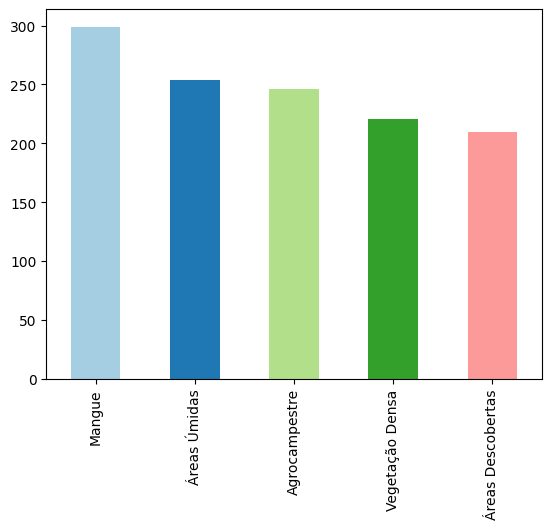

In [ ]:
# Gráfico de barras das contagens de classes em 'y'.
# Visualizar a distribuição dos dados e identificar desequilíbrios ou padrões nas classes

import matplotlib.pyplot as plt

# Obtém as contagens de cada classe em 'y' e cria um gráfico de barras com cores diferentes para cada barra.

y.value_counts().plot(kind="bar", color=plt.cm.Paired(range(len(y.value_counts()))))

# Exibe o gráfico.
plt.show()

# **Machine learning**

 Divisão dos dados em conjuntos de treinamento e teste utilizando a função

In [ ]:
# Divisão dos dados em conjuntos de treinamento e teste utilizando a função train_test_split.
# O conjunto de teste terá 30% dos dados, com semente aleatória 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Importação das classes enable_halving_search_cv e HalvingGridSearchCV do módulo sklearn.experimental.
# Estas classes permitem utilizar a técnica de busca em grade (Grid Search) com redução de amostras (Halving).

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# **RANDOM FOREST**

É um algoritmo de aprendizado de máquina que combina várias árvores de decisão usando amostragem por bootstrap e seleção aleatória de recursos. É eficaz em classificação e regressão

In [ ]:
# Dicionário 'p' com diferentes combinações de hiperparâmetros para a busca em grade.
p = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_samples': [0.8, 1],
}

# Instância do modelo Random Forest com estado aleatório 42.
rf = RandomForestClassifier(random_state=42)

# Aplicação da busca em grade ao modelo com validação cruzada (5 dobras).
cv_rf = GridSearchCV(estimator=rf, param_grid=p, cv=5)

# Treinamento do modelo com o conjunto de treinamento (X_train e y_train).
cv_rf.fit(X_train, y_train)


In [ ]:
# Melhores hiperparâmetros encontrados pela busca em grade (Grid Search) para o modelo Random Forest.
best_params = cv_rf.best_params_
best_params

In [ ]:
# Realiza a previsão do modelo treinado com os melhores hiperparâmetros no conjunto de teste (X_test).
y_pred = cv_rf.predict(X_test)

# Calcula a pontuação F1 usando as previsões e os rótulos verdadeiros do conjunto de teste (y_test),
# considerando a média micro para calcular a pontuação F1.
f1_score_micro_random = f1_score(y_test, y_pred, average='micro')


# A pontuação F1 micro é uma métrica de desempenho em tarefas de classificação.
print(f'Pontuação F1 do modelo Random Forest: {f1_score_micro_random:.2f}')


# **MLP**
Multilayer Perceptron (MLP) é um tipo de rede neural artificial com várias camadas ocultas que utiliza algoritmos de retropropagação para ajustar os pesos e realizar aprendizado supervisionado. É amplamente usado em classificação, regressão e reconhecimento de padrões em dados complexos

In [ ]:
# Dicionário 'p' com diferentes hiperparâmetros para busca em grade.
p = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [1],
    'max_iter': [1000],
}

# Instância do classificador MLP com três camadas ocultas de 100 neurônios cada.
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100,))

# Aplicação da busca em grade ao modelo MLP com validação cruzada (5 dobras).
cv_mlp = GridSearchCV(estimator=mlp, param_grid=p, cv=5)

# Treinamento do modelo MLP com o conjunto de treinamento (X_train e y_train).
cv_mlp.fit(X_train, y_train)


In [ ]:
# Melhores hiperparâmetros encontrados pela busca em grade (Grid Search) para o modelo Multilayer Perceptron (MLP).
best_params_ = cv_mlp.best_params_
best_params_

In [ ]:
# Realiza a previsão do modelo MLP treinado com os melhores hiperparâmetros no conjunto de teste (X_test).
y_pred = cv_mlp.predict(X_test,)

# Calcula a pontuação F1 usando as previsões feitas pelo modelo (y_pred) e os rótulos verdadeiros do conjunto de teste (y_test).
# A média micro é utilizada para calcular a pontuação F1, que é uma métrica de desempenho em tarefas de classificação.
f1_score_micro_MLP = f1_score(y_test, y_pred, average='micro')


# A pontuação F1 micro é uma métrica de desempenho em tarefas de classificação.
print(f'Pontuação F1 do modelo MLP: {f1_score_micro_MLP:.2f}')


# **SVC**

SVC (Support Vector Classification) é um algoritmo de aprendizado de máquina usado para problemas de classificação. Ele encontra um hiperplano ótimo para separar duas classes no espaço de características. É eficaz em problemas lineares e não lineares.

In [ ]:
# Dicionário 'p' com diferentes hiperparâmetros para busca em grade.

p = {
    'gamma': ['auto', 'scale'],
    'C': [0.5, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Instância do classificador SVC (Support Vector Classification).
svc = SVC()

# Aplicação da busca em grade ao modelo SVC com validação cruzada (5 dobras).
cv_svc = GridSearchCV(estimator=svc, param_grid=p, cv=5)

# Treinamento do modelo SVC com o conjunto de treinamento (X_train e y_train).
cv_svc.fit(X_train, y_train)


In [ ]:
# Melhores hiperparâmetros encontrados pela busca em grade (Grid Search) para o modelo Support Vector Classification (SVC).
best_params_ = cv_svc.best_params_
best_params_

In [ ]:
# Realiza a previsão do modelo SVC treinado com os melhores hiperparâmetros no conjunto de teste (X_test).
y_pred = cv_svc.predict(X_test)

# Calcula a pontuação F1 usando as previsões feitas pelo modelo (y_pred) e os rótulos verdadeiros do conjunto de teste (y_test).
# A média micro é utilizada para calcular a pontuação F1, que é uma métrica de desempenho em tarefas de classificação.
f1_score_micro_svc = f1_score(y_test, y_pred, average='micro')

# A pontuação F1 micro é uma métrica de desempenho em tarefas de classificação.
print(f'Pontuação F1 do modelo SVC: {f1_score_micro_svc:.2f}')

**XGBClassifier**

XGBClassifier é um algoritmo de aprendizado de máquina baseado em gradient boosting usado para classificação e regressão. Ele é eficiente, rápido e pode lidar com grandes conjuntos de dados

In [ ]:
# Dicionário 'p' com diferentes hiperparâmetros para busca em grade.

DEFAULT_RANDOM_STATE = 42

p = {
    'learning_rate': [0.01],
    'n_estimators': [100],
    'subsample': [0.8, 0.45],
    'min_child_weight': [1],
    'max_depth': [3, 4, 7],
    'random_state': [DEFAULT_RANDOM_STATE],
    'reg_lambda': [2],
}

# Instância do classificador XGBClassifier.
xgb = XGBClassifier()

# Aplicação da busca em grade ao modelo XGBClassifier com validação cruzada (5 dobras).
cv_xgb = GridSearchCV(estimator=xgb, param_grid=p, cv=5)

# Treinamento do modelo XGBClassifier com o conjunto de treinamento (X_train e y_train).
cv_xgb.fit(X_train, y_train)


In [ ]:
# Melhores hiperparâmetros encontrados pela busca em grade (Grid Search) para o modelo XGBClassifier.

best_params_ = cv_xgb.best_params_
best_params_

In [ ]:
# Realiza a previsão do modelo XGBClassifier treinado com os melhores hiperparâmetros no conjunto de teste (X_test).
y_pred = cv_xgb.predict(X_test)

# Calcula a pontuação F1 usando as previsões feitas pelo modelo (y_pred) e os rótulos verdadeiros do conjunto de teste (y_test).
# A média micro é utilizada para calcular a pontuação F1, que é uma métrica de desempenho em tarefas de classificação.
f1_score_micro_XGB = f1_score(y_test, y_pred, average='micro')


# A pontuação F1 micro é uma métrica de desempenho em tarefas de classificação.
print(f'Pontuação F1 do modelo XGBClassifier: {f1_score_micro_XGB:.2f}')


# Algoritimo com melhor desempenho na classificação

In [ ]:
print(f'Pontuação F1 do modelo Random Forest: {f1_score_micro_random:.2f}')

print(f'Pontuação F1 do modelo MLP: {f1_score_micro_MLP:.2f}')

print(f'Pontuação F1 do modelo SVC: {f1_score_micro_svc:.2f}')

print(f'Pontuação F1 do modelo XGBClassifier: {f1_score_micro_XGB:.2f}')



# Algoritmo Random Forest
selecionado, porque tem maior f1_score

In [ ]:
# Instância do modelo RandomForestClassifier com os hiperparâmetros selecionados.
rf = RandomForestClassifier(random_state=42,
                            max_depth=9,
                            max_samples=0.8,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            n_estimators=1000)



In [ ]:
# Treina o modelo RandomForestClassifier com o conjunto de treinamento (X_train e y_train).
rf.fit(X_train, y_train)


In [ ]:
# Imprime a dimensão do conjunto de dados de entrada (X).
print(X.shape)

# Imprime a dimensão do conjunto de rótulos (y).
print(y.shape)


In [ ]:
# Obtém os nomes das colunas (características) do conjunto de dados de entrada (X).
colnames = X.columns

# Cria um DataFrame 'feature_importances' contendo as importâncias das características,
# obtidas a partir do modelo RandomForestClassifier (rf), indexado pelos nomes das colunas.

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=colnames,
                                   columns=['importance'])


In [ ]:
# Cria uma figura com o tamanho de 12x5 polegadas para o gráfico de barras.
plt.figure(figsize=(12, 5))

# Cria um gráfico de barras utilizando o Seaborn (sns), onde o eixo x são os nomes das colunas (características)
# e o eixo y representa as importâncias das características, obtidas do DataFrame 'feature_importances'.
g = sns.barplot(x=colnames, y=feature_importances['importance'])

# Rotaciona os rótulos do eixo x em 90 graus para melhor legibilidade.
g.tick_params(axis='x', rotation=90)

# Exibe o gráfico de barras.
plt.show()


In [ ]:
# Importa a classe FeatureImportances da biblioteca Yellowbrick, que permite visualizar as importâncias das características.
from yellowbrick.features import FeatureImportances

# Cria uma figura com o tamanho de 15x10 polegadas para a visualização.
plt.figure(figsize=(15, 10))

# Instancia um modelo RandomForestClassifier.
model = RandomForestClassifier()

# Cria um objeto FeatureImportances com o modelo RandomForestClassifier.
viz = FeatureImportances(model)

# Ajusta o objeto FeatureImportances aos dados de entrada (X) e rótulos (y) para calcular as importâncias das características.
viz.fit(X, y)

# Mostra o gráfico de importâncias das características.
viz.show()


In [ ]:
import eli5
eli5.show_weights(rf, feature_names = X_train.columns.tolist())

In [ ]:
# Importando a função show_prediction da biblioteca eli5
from eli5 import show_prediction

# Exibindo a explicação das previsões feitas pelo modelo de Random Forest (rf) para um exemplo específico (X_train.iloc[1])
# feature_names é uma lista que contém os nomes das características (features) presentes no conjunto de treinamento (X_train)
# show_feature_values=True indica que queremos mostrar os valores das características (features) na explicação

show_prediction(rf, X_train.iloc[1], feature_names=X_train.columns.tolist(), show_feature_values=True)


In [ ]:
# Fazendo a previsão das classes ou valores usando o modelo de Random Forest (rf)
y_pred = rf.predict(X_test)


In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, X_test, y_test, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))

In [ ]:
# Extrai as classes alvo (rótulos) do DataFrame 'df' e armazena na variável 'y'.
y = df['classe']

# Remove a coluna 'classe' do DataFrame 'df' e armazena o restante dos dados na variável 'X'.
X = df.drop(columns=['classe'])


In [ ]:
X['mean_mde'][X['mean_mde'] < 0] = 0
X['q50_mde'][X['q50_mde'] < 0] = 0
X['sd_mde'][X['sd_mde'] < 0] = 0

In [ ]:
# Realiza a predição das classes utilizando o modelo Random Forest treinado 'rf' nos dados de entrada 'X'.
class_df = rf.predict(X)


In [ ]:
# Criação de um DataFrame chamado df_pred a partir de um objeto chamado class_df
df_pred = pd.DataFrame(class_df)


In [ ]:
# Importando a biblioteca "files" do Google Colab
from google.colab import files

# Salvando o DataFrame df_pred em um arquivo CSV chamado 'df_final.csv', sem incluir o índice
df_pred.to_csv('df_final.csv', index=False)

# Fazendo o download do arquivo 'df_final.csv' para o seu dispositivo local
files.download('df_final.csv')


# Comparar Algoritimos de machine learning

In [ ]:
# Dados com as pontuações F1-Score para diferentes modelos de Machine Learning
data = {'Random Forest': f1_score_micro_random,
        'XGBClassifier': f1_score_micro_XGB,
        'SVC': f1_score_micro_svc,
        'MLP': f1_score_micro_MLP}

# Lista dos modelos (chaves) e das pontuações F1-Score (valores)
courses = list(data.keys())
values = list(data.values())

# Criando uma figura (gráfico) com tamanho 10x5
fig = plt.figure(figsize=(10, 5))

# Criando um gráfico de barras
plt.bar(courses, values, width=0.4)

# Definindo o rótulo do eixo Y
plt.ylabel("F1-Score")

# Definindo o título do gráfico
plt.title("Avaliação dos modelos de Machine Learning")

# Exibindo o gráfico
plt.show()
